This notebook is used to support the ORKG-related statements made in the paper
<br><br>
<center>
"Examining the ORKG towards Representation of Control Theoretic Knowledge – Preliminary Experiences and Conclusions"

</center>
    
(currently under review).

Note: every SPARQL-Query can also be run via the web interface <https://www.orkg.org/orkg/sparql/>.

In [1]:
import time
print(time.ctime())
%load_ext ipydex.displaytools

Sun Feb 27 00:55:33 2022


In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML

sparql = SPARQLWrapper("https://www.orkg.org/orkg/triplestore/")
sparql.setReturnFormat(JSON)

prefixes = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

"""

**Claim:**  At the time of writing, the ORKG SPARQL query service lists
101218 distinct nodes (excluding literal values) and 4699 properties.


In [3]:
qs = """
SELECT  (COUNT(distinct ?vertex) AS ?count)
WHERE
{
  {
    ?vertex ?p []
  }
  UNION
  {
    [] ?p ?vertex
    FILTER(!IsLiteral(?vertex))
  }
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"] ##:

q := [{'count': {'type': 'typed-literal',
   'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
   'value': '101218'}}]

---

In [4]:
qs = """
SELECT  (COUNT(distinct ?p) AS ?count)
WHERE
{
  {
    ?vertex ?p []
  }
  UNION
  {
    [] ?p ?vertex
    FILTER(!IsLiteral(?vertex))
  }
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"] ##:

q := [{'count': {'type': 'typed-literal',
   'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
   'value': '4699'}}]

---

---

**Claim:**  At the time of writing, the ORKG SPARQL query service lists
101218 distinct nodes (excluding literal values) and 4699 properties.


In [5]:
with open("dump2.nt") as thefile:
    lines = thefile.readlines()
    
print(len(lines))
new_lines = []
for l in lines:
    if "<null>" in l:
        continue
    new_lines.append(l)

687670


---

**Claim:** At the beginning of this study (2022-01-15) there are five papers
listed under research field Control Theory (R109).


In [6]:
qs = prefixes + """
select distinct ?paper ?title where
  {?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  MINUS { ?paper rdf:type orkgc:PaperDeleted . }
  }
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

In [7]:
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,paper,title
0,http://orkg.org/orkg/resource/R138527,Sensitivity analysis applied to a variational ...
1,http://orkg.org/orkg/resource/R138532,Incremental projection approach of regularizat...
2,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...
3,http://orkg.org/orkg/resource/R146974,Data-Enabled Predictive Control: In the Shallo...
4,http://orkg.org/orkg/resource/R146978,Data-Driven Model Predictive Control With Stab...


---

**Claim:** The control-theoretic papers have between 1 and five associated (via `P32`) research problems.


In [8]:
qs = prefixes + """
SELECT distinct ?paper ?title ?rpLabel WHERE
{
  ?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb orkgp:P32 ?rp.     # research problems
  ?rp rdfs:label ?rpLabel.
  MINUS { ?paper rdf:type orkgc:PaperDeleted . }

}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,paper,title,rpLabel
0,http://orkg.org/orkg/resource/R138527,Sensitivity analysis applied to a variational ...,Adjoint based sensitivity
1,http://orkg.org/orkg/resource/R138532,Incremental projection approach of regularizat...,L2 Regularization
2,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,Adaptive control of fluid resuscitation
3,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,modeling blood pressure response to infusion a...
4,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,automatic resusictation therapy
5,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,closed-loop fluid resuscitation
6,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,In-silico evaluation of closed-loop controllers
7,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,closed-loop control of hemorrhage resusication
8,http://orkg.org/orkg/resource/R146974,Data-Enabled Predictive Control: In the Shallo...,data-driven predictive control using input-out...
9,http://orkg.org/orkg/resource/R146978,Data-Driven Model Predictive Control With Stab...,data-driven predictive control using input-out...


---

**Claim:**  Of these ten research problems two posses a description (via orkgp:description)


In [9]:
qs = prefixes + """
SELECT distinct ?rpLabel ?predicate ?obj WHERE
{
  ?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb orkgp:P32 ?rp.     # research problems
  ?rp rdfs:label ?rpLabel.
  ?rp ?predicate ?obj.
  
  MINUS {
  ?paper rdf:type orkgc:PaperDeleted.
  }
  
  FILTER(?predicate !=  rdf:type )
  FILTER(?predicate !=  rdfs:label )

}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,rpLabel,predicate,obj
0,Adjoint based sensitivity,http://orkg.org/orkg/predicate/description,sensitivity analysis; variational data assimil...
1,data-driven predictive control using input-out...,http://orkg.org/orkg/predicate/description,The predictive model in the predictive control...


In [10]:
for r in flat_result_list:
    print(f"description of research problem '{r['rpLabel']}':\n'{r['obj']}'\n\n")

description of research problem 'Adjoint based sensitivity':
'sensitivity analysis; variational data assimilation; adjoint method; pollution; optimal control;
inverse problem'


description of research problem 'data-driven predictive control using input-output data':
'The predictive model in the predictive control problem is now replaced by a set of input/output data matrices'




---

**Claim:**  All together there are 29 statements associated with the five contributions, and the by far most frequently used property is the just mentioned `has research problem` (`P32`, 14 times).

In [11]:
qs = prefixes + """
SELECT distinct ?property ?propertyLabel (COUNT(?property) AS ?propertyCount)
WHERE
{
  ?paper orkgp:P30 orkgr:R109.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb ?property ?obj.     # any relation of the contribution to some object
  ?property rdfs:label ?propertyLabel

  FILTER(?property != rdfs:label)
  FILTER(?property != rdf:type)

}
GROUP BY ?property ?propertyLabel
ORDER BY DESC(?propertyCount)
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
df = pd.DataFrame(flat_result_list) ##:

,property,propertyLabel,propertyCount
0,http://orkg.org/orkg/predicate/P32,has research problem,14
1,http://orkg.org/orkg/predicate/P41907,Mathematical model,2
2,http://orkg.org/orkg/predicate/P41911,Theoretical guarantees,2
3,http://orkg.org/orkg/predicate/P41912,Robustness analysis,2
4,http://orkg.org/orkg/predicate/P21,programming language,2
5,http://orkg.org/orkg/predicate/P41909,Mathematical model used In-silico study,2
6,http://orkg.org/orkg/predicate/P35214,Has example,2
7,http://orkg.org/orkg/predicate/P41908,Experimental validation of mathematical model,2
8,http://orkg.org/orkg/predicate/P41910,In-vivo study,1


---

In [12]:
df["propertyCount"].astype(int).sum()

29

**Note:** This query does not yet exclude deleted papers. This should be corrected in the revised version.

---

**Claim:** `Has example` (`P35214`) is used for two papers/contributions and has literal string values.

In [13]:
qs = prefixes + """
SELECT distinct ?title ?propertyLabel ?pvalue
WHERE
{
  ?paper orkgp:P30 orkgr:R109;
         rdfs:label ?title.
  ?paper orkgp:P31 ?ctrb.  # contribution
  
  ?ctrb ?property ?pvalue.
  VALUES ?property {orkgp:P35214}.  
  ?property rdfs:label ?propertyLabel.
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
df = pd.DataFrame(flat_result_list) ##:

,title,propertyLabel,pvalue
0,Data-Enabled Predictive Control: In the Shallo...,Has example,yes - quadcoptor
1,Data-Driven Model Predictive Control With Stab...,Has example,yes - four tank system


---

---

**Claim:**  With five associated papers control theory is in the center field of the ordered list of all research fields.

In [14]:
qs = prefixes + """
SELECT ?field ?fieldLabel (COUNT(?paper) AS ?paperCount)
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P30 ?field.
  ?paper rdfs:label ?title.
  ?field rdfs:label ?fieldLabel.

}
GROUP BY ?field ?fieldLabel
ORDER BY DESC(?paperCount)
LIMIT 1000
"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [15]:
df = pd.DataFrame(flat_result_list)
idx = np.flatnonzero(df["fieldLabel"] == "Control Theory")[0]
paper_count = (df["paperCount"]).astype(int).to_numpy() ##:i

info(paper_count) := "<class 'numpy.ndarray'> with shape: (228,)"

---

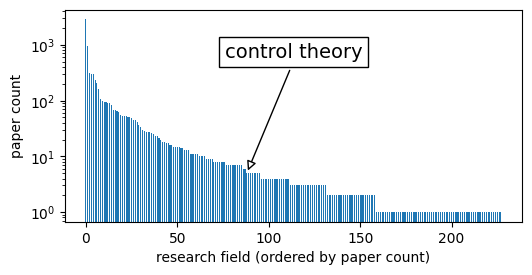

In [16]:
mm = 1/25.4 # mm to inch
scale = 2
fs = [75*mm*scale, 35*mm*scale]
plt.figure(figsize=fs, dpi=100)
n_fields = len(paper_count)
plt.bar(np.arange(n_fields), paper_count, width=0.6)
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel("paper count")
plt.xlabel("research field (ordered by paper count)")


ann = ax.annotate("control theory",
                  xy=(idx, 5), xycoords='data',
                  xytext=(0.5, 0.8), textcoords='axes fraction',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="Square", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.0",
                                  relpos=(0.5, 0.),
                                  fc="w"),
                  )


plt.show()

---

**Claim:**  The highest ranked research fields (w.r.t. to the number of associated papers are "Science" (R11, 2891 papers), "Ecology"8 (R50, 966 papers), "Information science" (R278, 307 papers) and "Artificial
Intelligence" (R133, 301 papers).


In [17]:
df[:5]

,field,fieldLabel,paperCount
0,http://orkg.org/orkg/resource/R11,Science,2891
1,http://orkg.org/orkg/resource/R50,Motor Control,966
2,http://orkg.org/orkg/resource/R278,Information Science,307
3,http://orkg.org/orkg/resource/R133,Artificial Intelligence,301
4,http://orkg.org/orkg/resource/R69,Toxicology,295


**Note:** 8 Interestingly, the label for the second Research Field-instance in this list is "Motor control" and it has "Neurons and Cognition" as asserted synonym, which both seem to be wrong, at least according to titles of the associated papers, e. g. “Incorporation of an invasive plant into a native insect herbivore food web”. The label "Ecology" is used by the author due to the lack of a more specific one.

---

**Claim:** About 70% of `Research Problem` resources are related to only one paper.



In [18]:
qs = prefixes + """
SELECT ?researchproblem ?researchproblemLabel (COUNT(?paper) AS ?paperCount)
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P31 ?contribution.
  ?contribution orkgp:P32 ?researchproblem.
  ?researchproblem rdfs:label ?researchproblemLabel.

}
GROUP BY ?researchproblem ?researchproblemLabel
ORDER BY DESC(?paperCount)
LIMIT 10000
"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [19]:
df = pd.DataFrame(flat_result_list)
paper_count = (df["paperCount"]).astype(int).to_numpy() ##:i

info(paper_count) := "<class 'numpy.ndarray'> with shape: (2025,)"

---

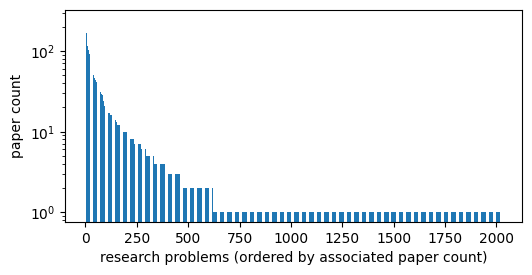

In [20]:
plt.figure(figsize=fs, dpi=100)
n_fields = len(paper_count)
plt.bar(np.arange(n_fields), paper_count, width=0.6)
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel("paper count")
plt.xlabel("research problems (ordered by associated paper count)")

plt.show()

---

**Claim:** The median of *property-reuse* is less then 0.1%.




In [21]:
qs = prefixes + """
# count papers whose contributions are associated with the same property
SELECT ?prop ?propLabel (COUNT(DISTINCT ?paper) AS ?paperCount)
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P31 ?contribution.
  ?contribution ?prop ?object. # contribution has any property
  ?prop rdfs:label ?propLabel.

}
GROUP BY ?prop ?propLabel
ORDER BY DESC(?paperCount)
LIMIT 10000
"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [22]:
df = pd.DataFrame(flat_result_list)
paper_count = (df["paperCount"]).astype(int).to_numpy() ##:i
paper_percentage = paper_count/np.max(paper_count) *100
med = np.median(paper_percentage)

info(paper_count) := "<class 'numpy.ndarray'> with shape: (3203,)"

---

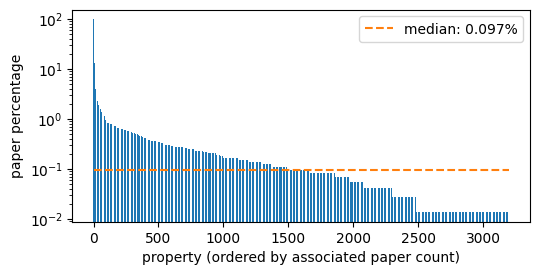

In [23]:
plt.figure(figsize=fs, dpi=100)
n_fields = len(paper_percentage)
plt.bar([0], [100], width=5) # ensure that the first bar is visible
plt.bar(np.arange(n_fields), paper_percentage, width=0.6, color="#1f77b4")

plt.plot([0, n_fields], [med, med], "--", label=f"median: {med:04.3f}%", color="#ff7f0e")
plt.legend(loc="upper right")

ax = plt.gca()
ax.set_yscale('log')
plt.ylabel("paper percentage")
plt.xlabel("property (ordered by associated paper count)")

plt.show()

---

**Claim:** The property `Has example` (`P35214`) has semantically dubious values of string literals.




In [24]:
qs = prefixes + """
SELECT ?paper ?prop ?example
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P30 orkgr:R109.  # ... from research field control theory
  ?paper orkgp:P31 ?contribution.
  
  VALUES ?prop {orkgp:P35214}.
  ?contribution ?prop ?example. # ?contribution <Has example> ?example
  
  MINUS { ?paper rdf:type orkgc:PaperDeleted . }
}

"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [25]:
df = pd.DataFrame(flat_result_list) ##:

,paper,prop,example
0,http://orkg.org/orkg/resource/R146974,http://orkg.org/orkg/predicate/P35214,yes - quadcoptor
1,http://orkg.org/orkg/resource/R146978,http://orkg.org/orkg/predicate/P35214,yes - four tank system


---

---

**Claim:** There are five `orkgp:`-properties with the label "description" (ignoring case).


In [26]:
qs = prefixes + """
SELECT DISTINCT ?prop ?propLabel where
  {
    # Values ?prop {orkgp:P12}.
    ?prop a orkgc:Predicate.
    
    # VALUES ?prop {orkgp:description}
    ?prop rdfs:label ?propLabel.
    {
      ?prop rdfs:label "description"^^xsd:string.
    }
    UNION
    {
      ?prop rdfs:label "Description"^^xsd:string.
    }
}

"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [27]:
df = pd.DataFrame(flat_result_list) ##:

,prop,propLabel
0,http://orkg.org/orkg/predicate/P14,description
1,http://orkg.org/orkg/predicate/description,description
2,http://orkg.org/orkg/predicate/P7037,Description
3,http://orkg.org/orkg/predicate/P7214,Description
4,http://orkg.org/orkg/predicate/P7224,Description


---

---

**Claim:** There are over 100 `Paper`-entities which have the same title.


In [28]:
qs = prefixes + """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?o1Label (GROUP_CONCAT(?o1, " ") AS ?o1Group) (COUNT(?o1Label) AS ?o1LabelCount)
WHERE {
  ?o1 a orkgc:Paper.
  ?o1 rdfs:label ?o1Label.
  
  FILTER (strlen(?o1Label) > 1).
}

GROUP BY ?o1Label
ORDER BY DESC(?o1LabelCount)

"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

df = pd.DataFrame(flat_result_list) ##:i

info(df) := "<class 'pandas.core.frame.DataFrame'> with shape: (7808, 3)"

---

In [29]:
display(HTML(df[:10].to_html(col_space=["40em", "10em", "10em"])))

,o1Label,o1Group,o1LabelCount
0,Governing nonprofit platform ecosystems – an information platform for refugees,http://orkg.org/orkg/resource/R9280 http://orkg.org/orkg/resource/R9282 http://orkg.org/orkg/resource/R9283 http://orkg.org/orkg/resource/R9284 http://orkg.org/orkg/resource/R9285 http://orkg.org/orkg/resource/R9286 http://orkg.org/orkg/resource/R9287 http://orkg.org/orkg/resource/R9288 http://orkg.org/orkg/resource/R9289 http://orkg.org/orkg/resource/R9290 http://orkg.org/orkg/resource/R9291 http://orkg.org/orkg/resource/R9292 http://orkg.org/orkg/resource/R9293 http://orkg.org/orkg/resource/R9294,14
1,Solution-processed high-performance p-channel copper tin sulfide thin-film transistors,http://orkg.org/orkg/resource/R145533 http://orkg.org/orkg/resource/R145535 http://orkg.org/orkg/resource/R145536 http://orkg.org/orkg/resource/R145537 http://orkg.org/orkg/resource/R145549,5
2,Two New Phytoecdysteroids From Sphenocentrum jollyanum Pierre Root,http://orkg.org/orkg/resource/R77208 http://orkg.org/orkg/resource/R78075 http://orkg.org/orkg/resource/R78077 http://orkg.org/orkg/resource/R78084,4
3,"Present-Day Atmospheric Simulations Using GISS ModelE: Comparison to In Situ, Satellite, and Reanalysis Data",http://orkg.org/orkg/resource/R23338 http://orkg.org/orkg/resource/R23353 http://orkg.org/orkg/resource/R23368 http://orkg.org/orkg/resource/R23383,4
4,Model and heuristics for the Assembly Line Worker Integration and Balancing Problem,http://orkg.org/orkg/resource/R12182 http://orkg.org/orkg/resource/R12183 http://orkg.org/orkg/resource/R12184 http://orkg.org/orkg/resource/R12185,4
5,BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding,http://orkg.org/orkg/resource/R12208 http://orkg.org/orkg/resource/R12209 http://orkg.org/orkg/resource/R12210 http://orkg.org/orkg/resource/R12211,4
6,A Graph Based Tool for Modelling Planning Processes in Building Engineering,http://orkg.org/orkg/resource/R4693 http://orkg.org/orkg/resource/R4717 http://orkg.org/orkg/resource/R4735 http://orkg.org/orkg/resource/R5138,4
7,Bibliographic ontology specification,http://orkg.org/orkg/resource/R8335 http://orkg.org/orkg/resource/R9527 http://orkg.org/orkg/resource/R9560,3
8,SMDM: enhancing enterprise-wide master data management using semantic web technologies,http://orkg.org/orkg/resource/R38016 http://orkg.org/orkg/resource/R8689 http://orkg.org/orkg/resource/R8707,3
9,Optimization of Pulsed Electric Field Treatment for the Extraction of Bioactive Compounds from Blackcurrant,http://orkg.org/orkg/resource/R75010 http://orkg.org/orkg/resource/R75365 http://orkg.org/orkg/resource/R75366,3


In [30]:
# number of papers which are probably duplicated (exact same title)
(df["o1LabelCount"].astype(int) > 1).sum()

121

---

**Claim:** There are over 1000 unused properties, i.e. `Predicates`-entities which are never used in the middle position of a triple.

In [31]:
qs = prefixes + """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT DISTINCT  ?prop ?propType ?propLabel where
  {
    # Values ?prop {orkgp:P12}.
    ?prop a orkgc:Predicate.
          ?prop rdfs:label ?propLabel.

    Minus {
      ?o1 ?prop ?o2.
      }

}

"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [32]:
df = pd.DataFrame(flat_result_list) ##:i

info(df) := "<class 'pandas.core.frame.DataFrame'> with shape: (1088, 2)"

---

---

**Claim:** There are over 150 papers without a single author.

In [33]:
qs = prefixes + """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?paper ?paperLabel ?author ?authorLabel
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P30 orkgr:R11.
  ?paper rdfs:label ?paperLabel.

  MINUS {?paper orkgp:P27 ?author.}
}
LIMIT 1000

"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [34]:
df = pd.DataFrame(flat_result_list) ##:i

info(df) := "<class 'pandas.core.frame.DataFrame'> with shape: (162, 2)"

---